
# AR vs ARX — Prediksjon av trading volume (mal)

Denne notatboka er en **grunnmal** for å sammenligne en standard tidsseriemodell (AR/ARMA) mot en variant med **eksogene variabler** (ARX/ARMAX).  
Bytt kun innholdet i **Boks A** og **Boks B** for andre modellpar (f.eks. ARIMA vs ARIMAX, SARIMA vs SARIMAX).

**Datasett** forventes i `./data/merged_volume_volatility.csv` med minst følgende kolonner:
- `date`
- `volume_all` (eller bruk `log_volume` dersom du vil starte på log-skala)
- `hist_vol` og/eller `vix` samt forhåndsloggede varianter (`log_hist_vol`, `log_vix`)

> Tips: Kjør hele "Oppsett" først. Deretter kan du eksperimentere i Boks A/B.


In [1]:
# --- Pakker og oppsett ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit
from typing import Optional, Tuple, Dict, Any, List

pd.options.display.float_format = "{:,.4f}".format
plt.rcParams["figure.figsize"] = (9, 4)


In [2]:
# --- Last data ---
CSV_PATH = "merged_volume_volatility.csv"  

df = pd.read_csv(CSV_PATH)
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date").sort_index()

df = df[df.index <= "2024-12-31"]

# Velg hvilke kolonner du vil jobbe på som standard
target_col = "log_volume" if "log_volume" in df.columns else "volume_all"

# Håndter manglende data (enkelt og konservativt):
df = df.replace([np.inf, -np.inf], np.nan).dropna(how="any")

print("Kolonner:", list(df.columns))
display(df.head())


Kolonner: ['volume_all', 'hist_vol', 'vix', 'log_volume', 'log_hist_vol', 'log_vix']


,volume_all,hist_vol,vix,log_volume,log_hist_vol,log_vix
date,,,,,,
2004-01-01,"3,213,291,345.0000",9.6015,18.2200,21.8906,2.2619,2.9025
2004-01-02,"3,213,291,345.0000",9.6015,18.2200,21.8906,2.2619,2.9025
2004-01-05,"4,529,997,306.0000",10.1242,17.4900,22.2340,2.3149,2.8616
2004-01-06,"4,308,224,839.0000",10.1254,16.7300,22.1838,2.3150,2.8172
2004-01-07,"4,697,460,900.0000",9.5426,15.5000,22.2703,2.2558,2.7408


Mål (y): log_volume | Logg valgt: False
Tilgjengelige eksogene kandidater: ['vix', 'log_vix', 'hist_vol', 'log_hist_vol']
ADF p-verdi: 0.0957 (lav p tyder på stasjonaritet)


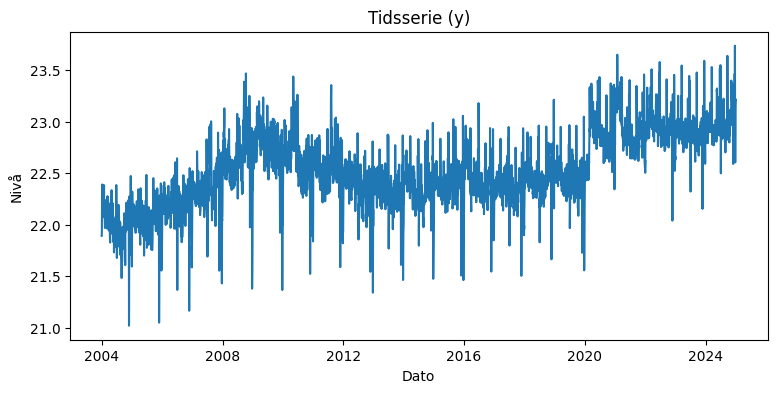

In [3]:
# --- Preprosessering: opsjon for å logge volum ---
y_raw = df[target_col].copy()

USE_LOG_TRANSFORM = False if target_col == "log_volume" else True
if USE_LOG_TRANSFORM:
    y = np.log1p(y_raw)
else:
    y = y_raw.copy()

# Valgfrie eksogene kandidater (du justerer konkret i Boks B):
exog_candidates = []
for c in ["vix", "log_vix", "hist_vol", "log_hist_vol"]:
    if c in df.columns:
        exog_candidates.append(c)

print("Mål (y):", target_col, "| Logg valgt:", USE_LOG_TRANSFORM)
print("Tilgjengelige eksogene kandidater:", exog_candidates)

# Enkle stasjonaritetstester (ADF)
adf_stat, pval, *_ = adfuller(y.dropna())
print(f"ADF p-verdi: {pval:.4f} (lav p tyder på stasjonaritet)")

# Plot y
plt.plot(y.index, y.values)
plt.title("Tidsserie (y)"); plt.xlabel("Dato"); plt.ylabel("Nivå")
plt.show()


In [4]:
# --- Tidsserie-split ---
def time_split(series: pd.Series, train_frac=0.7, val_frac=0.15):
    n = len(series)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)
    train_idx = series.index[:n_train]
    val_idx = series.index[n_train:n_train+n_val]
    test_idx = series.index[n_train+n_val:]
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = time_split(y, train_frac=0.7, val_frac=0.15)
y_train, y_val, y_test = y.loc[train_idx], y.loc[val_idx], y.loc[test_idx]

print(f"Split: train={y_train.shape[0]}, val={y_val.shape[0]}, test={y_test.shape[0]}")


Split: train=3835, val=821, test=823


In [5]:
# --- Hjelpefunksjoner for SARIMAX (AR/ARMA/ARX/ARMAX) ---

def fit_sarimax(endog: pd.Series,
                order: Tuple[int,int,int]=(1,0,0),
                exog: Optional[pd.DataFrame]=None):
    model = SARIMAX(endog, order=order, trend="n", exog=exog,
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    return res

def aic_grid_search(endog: pd.Series,
                    p_vals: List[int], q_vals: List[int],
                    exog: Optional[pd.DataFrame]=None):
    best = {"aic": np.inf, "order": None, "res": None}
    for p in p_vals:
        for q in q_vals:
            try:
                res = fit_sarimax(endog, order=(p,0,q), exog=exog)
                if res.aic < best["aic"]:
                    best = {"aic": res.aic, "order": (p,0,q), "res": res}
            except Exception:
                continue
    return best

def forecast_with_refit(series: pd.Series,
                        start_idx: int,
                        horizon: int = 1,
                        order: Tuple[int,int,int]=(1,0,0),
                        exog_full: Optional[pd.DataFrame]=None):
    # rullerende enkestegs prognoser med refit
    preds = []
    for t in range(start_idx, len(series)-horizon+1):
        endog = series.iloc[:t]
        exog = exog_full.iloc[:t] if exog_full is not None else None
        res = fit_sarimax(endog, order=order, exog=exog)
        exog_future = exog_full.iloc[t:t+horizon] if exog_full is not None else None
        fc = res.forecast(steps=horizon, exog=exog_future)
        preds.append(fc.iloc[-1])
    return np.array(preds)

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def diebold_mariano(e1, e2, h=1, alternative="two-sided"):
    # enkel DM-test for kvadrert feil
    d = (e1**2 - e2**2)
    d_bar = np.mean(d)
    T = len(d)
    gamma0 = np.var(d, ddof=1)
    s = gamma0
    for k in range(1, h):
        gamma_k = np.cov(d[k:], d[:-k], ddof=1)[0,1]
        w = 1 - k/(h+1)
        s += 2 * w * gamma_k
    dm_stat = d_bar / np.sqrt(s/T)
    from scipy.stats import norm
    if alternative == "two-sided":
        p = 2 * (1 - norm.cdf(np.abs(dm_stat)))
    elif alternative == "less":
        p = norm.cdf(dm_stat)
    else:
        p = 1 - norm.cdf(dm_stat)
    return {"dm_stat": float(dm_stat), "p_value": float(p)}


## Boks A — Standardmodell (MA)

/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfugler

Beste standard-order (p,0,q): (0, 0, 3) | AIC: 20409.307646078676


/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfugler

MA — Test RMSE: 3.5617 | MAE: 3.3728


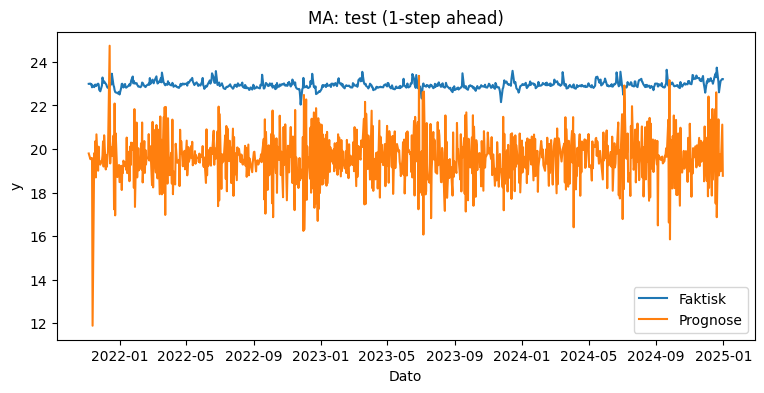

In [6]:
# --- Velg orden (p,q) for AR/ARMA ---
P_GRID = [0]
Q_GRID = [0,1,2,3]

best_std = aic_grid_search(y_train, p_vals=P_GRID, q_vals=Q_GRID, exog=None)
print("Beste standard-order (p,0,q):", best_std["order"], "| AIC:", best_std["aic"])

# Refit på train+val
y_trval = pd.concat([y_train, y_val])
res_std = fit_sarimax(y_trval, order=best_std["order"])

# Out-of-sample rullerende 1-stegs prognose på test
start_idx = len(y_trval)
y_full = pd.concat([y_trval, y_test])
preds_std = forecast_with_refit(y_full, start_idx=start_idx, horizon=1, order=best_std["order"])

y_test_np = y_test.values[:len(preds_std)]
rmse_std = rmse(y_test_np, preds_std)
mae_std = mae(y_test_np, preds_std)
print(f"MA — Test RMSE: {rmse_std:.4f} | MAE: {mae_std:.4f}")

plt.plot(y_test.index[:len(preds_std)], y_test_np, label="Faktisk")
plt.plot(y_test.index[:len(preds_std)], preds_std, label="Prognose")
plt.title("MA: test (1-step ahead)"); plt.xlabel("Dato"); plt.ylabel("y")
plt.legend()
plt.show()


## Boks B — Modell med eksogene variabler (MAX)

In [ ]:
# --- Velg eksogene kolonner og eventuelle lag ---
EXOG_COLS = [c for c in ["log_vix"] if c in df.columns]
# , "log_hist_vol", "vix", "hist_vol"
LAG_EXOG = 1  # sett 0 hvis du vil bruke samtidige verdier

if LAG_EXOG > 0:
    exog_df = df[EXOG_COLS].shift(LAG_EXOG).iloc[:]
else:
    exog_df = df[EXOG_COLS].iloc[:]

data = pd.concat([y.rename("y"), exog_df], axis=1).dropna()
y_aligned = data["y"]
X_aligned = data[EXOG_COLS]

train_idx, val_idx, test_idx = time_split(y_aligned, train_frac=0.7, val_frac=0.15)
y_train, y_val, y_test = y_aligned.loc[train_idx], y_aligned.loc[val_idx], y_aligned.loc[test_idx]
X_train, X_val, X_test = X_aligned.loc[train_idx], X_aligned.loc[val_idx], X_aligned.loc[test_idx]

best_ex = aic_grid_search(y_train, p_vals=[0], q_vals=[0,1,2,3], exog=X_train)
print("Beste MAX (p,0,q):", best_ex["order"], "| AIC:", best_ex["aic"])

y_trval = pd.concat([y_train, y_val])
X_trval = pd.concat([X_train, X_val])
res_ex = fit_sarimax(y_trval, order=best_ex["order"], exog=X_trval)

y_full = pd.concat([y_trval, y_test])
X_full = pd.concat([X_trval, X_test])
start_idx = len(y_trval)
preds_ex = forecast_with_refit(y_full, start_idx=start_idx, horizon=1, order=best_ex["order"], exog_full=X_full)

y_test_np = y_test.values[:len(preds_ex)]
rmse_ex = rmse(y_test_np, preds_ex)
mae_ex = mae(y_test_np, preds_ex)
print(f"MAX — Test RMSE: {rmse_ex:.4f} | MAE: {mae_ex:.4f}")

plt.plot(y_test.index[:len(preds_ex)], y_test_np, label="Faktisk")
plt.plot(y_test.index[:len(preds_ex)], preds_ex, label="Prognose")
plt.title("MAX: test (1-step ahead)"); plt.xlabel("Dato"); plt.ylabel("y")
plt.legend()
plt.show()


## Sammenligning og Diebold–Mariano-test

In [ ]:

# Sørg for at begge prediksjonsseriene er samme lengde
n = min(len(preds_std), len(preds_ex))
preds_std_c = preds_std[-n:]
preds_ex_c = preds_ex[-n:]
y_cmp = y_test.values[-n:]

e_std = y_cmp - preds_std_c
e_ex  = y_cmp - preds_ex_c

print("RMSE — Standard:", rmse(y_cmp, preds_std_c), "| ARX/ARMAX:", rmse(y_cmp, preds_ex_c))
print("MAE  — Standard:", mae(y_cmp, preds_std_c),  "| ARX/ARMAX:", mae(y_cmp, preds_ex_c))

dm = diebold_mariano(e_std, e_ex, h=1, alternative="two-sided")
print("DM-stat:", dm["dm_stat"], "p-verdi:", dm["p_value"])


## Diagnostikk (siste fit på train+val)

In [ ]:

# Standardmodell residualdiagnostikk
resid_std = res_std.resid
lb_std = acorr_ljungbox(resid_std, lags=[10], return_df=True)
print("Ljung-Box (std, lag 10):")
display(lb_std)

plt.plot(resid_std.index, resid_std.values)
plt.title("Residualer — Standardmodell"); plt.xlabel("Dato"); plt.ylabel("Resider")
plt.show()

# ARX/ARMAX residualdiagnostikk
resid_ex = res_ex.resid
lb_ex = acorr_ljungbox(resid_ex, lags=[10], return_df=True)
print("Ljung-Box (exog, lag 10):")
display(lb_ex)

plt.plot(resid_ex.index, resid_ex.values)
plt.title("Residualer — ARX/ARMAX"); plt.xlabel("Dato"); plt.ylabel("Resider")
plt.show()



### Hva endrer du når du dupliserer notatboka?
- I **Boks A**: bytt `order`-søk, evt. differensiering/sesong (gå da til ARIMA/SARIMA via `order=(p,d,q)`).
- I **Boks B**: bytt hvilke eksogene (`EXOG_COLS`) og lag (`LAG_EXOG`) du bruker. For RV vs IV: f.eks. `["log_hist_vol"]` vs `["log_vix"]`.
- Resten kan stå uendret slik at evaluering og sammenligning er konsistent.
